### Image Augmentation Lab: Cut Out and Mix Up Techniques
__Content creator:__ [Pranav Poudel](https://www.linkedin.com/in/pranavpoudel/)

----
### Objective

The objective of this lab is to empower students to implement Mixup and Cutoff data augmentation techniques and analyze their effects through visualization. By engaging in this hands-on experience, students will develop the skills to effectively apply these techniques to their datasets, observe the transformations induced by Mixup and Cutoff, and understand how these augmentations contribute.

### Import important modules


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm import tqdm

# from models import get_resnet18

### Function for Fixing Seeds

In [2]:
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

### Model:- ResNet18
ResNet is a deep convolutional neural network architecture that uses residual connections to address the problem of vanishing gradients. By enabling the direct flow of gradients through the network, ResNet allows for training very deep networks and has achieved state-of-the-art performance in computer vision tasks. Its residual blocks and skip connections have had a significant impact on advancing the performance of convolutional neural networks.
See the [original paper](https://arxiv.org/abs/1512.03385) for more details.

In [3]:
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type


class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return  out
    
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        feat = self.avgpool(x)
        x = torch.flatten(feat, 1)
        x = self.fc(x)
        return x, feat


def get_resnet18(in_channels, num_classes):
    """
    Args:
        in_channels:- channel of input image. 3 for RGB
        num_classes:- Number of classes to classify. 
    """
    return ResNet(img_channels=in_channels, num_layers=18, block=BasicBlock, num_classes=num_classes)

### Hyper-parameters


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

start_epoch = 0  
batch_size = 32
end_epoch = 10
base_learning_rate = 0.0002
b1 = 0.5
b2 = 0.999
### Below are hyper-parameters related to augmentation technique
n_holes = 1
length = 4
cutout = False
mixup = True
set_seed(42)

Random seed 42 has been set.


<h3>Task 1: Implement Cutout Augmentation</h3>

In given object code below, implement the Cutout Augmentation in __call__ function. See the [original paper](https://arxiv.org/pdf/1708.04552.pdf) for more details.

##### Algorithm: Cutout Augmentation

Inputs:
- img: Input image tensor
- n_holes: Number of cutout holes to apply
- length: Length of each cutout hole

Output:
- Augmented image tensor

Procedure:
1. Get the height (h) and width (w) of the input image tensor.
2. Create a mask tensor of size (h, w) filled with ones of data type float32.
3. Repeat the following steps for each cutout hole (n) from 1 to n_holes:
   
   a. Generate random coordinates (y, x) within the image dimensions (h, w).
   
   b. Calculate the boundaries of the cutout hole based on the length:
      - y1 = max(y - length // 2, 0)
      - y2 = min(y + length // 2, h)
      - x1 = max(x - length // 2, 0)
      - x2 = min(x + length // 2, w)
      
   c. Set the corresponding region in the mask tensor to 0, indicating the cutout hole.
4. Convert the mask tensor to a PyTorch tensor.
5. Expand the mask tensor to match the size of the input image tensor.
6. Multiply the input image tensor element-wise with the mask tensor to apply the cutout holes.
7. Return the augmented image tensor.



In [25]:

class Cutout(object):

  def __init__(self, n_holes, length):
    self.n_holes = n_holes
    self.length = length

  def __call__(self, img):
    h = img.size(1)
    w = img.size(2)

    mask = np.ones((h, w), np.float32)

    for n in range(self.n_holes):
      y = np.random.randint(h)
      x = np.random.randint(w)

      y1 = np.clip(y - self.length // 2, 0, h)
      y2 = np.clip(y + self.length // 2, 0, h)
      x1 = np.clip(x - self.length // 2, 0, w)
      x2 = np.clip(x + self.length // 2, 0, w)

      mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img = img * mask

    return img

<h3>Task 2: Implement Mixup Augmentation</h3>

Implement Mixup Augmenation in mixup_data function below. See the [original paper](https://arxiv.org/pdf/1710.09412.pdf) for more details.


##### Algorithm: Mixup Data

Inputs:
- x: Input data tensor
- y: Target labels tensor
- alpha: Alpha parameter for mixup (default: 1.0)

Outputs:
- mixed_x: Mixed input data tensor
- y_a: First set of target labels tensor
- y_b: Second set of target labels tensor
- lam: Lambda value for mixing

Procedure:
1. If alpha > 0, generate a random lambda value (lam) by sampling from a Beta distribution with alpha as both shape parameters. Otherwise, set lam = 1.

2. Get the batch size from the input data tensor x.

3. Generate a random permutation of indices using torch.randperm(batch_size).

4. Calculate the mixed input data (mixed_x) by linearly combining the input data x and its permuted counterpart, 
according to the lambda value:

   mixed_x = lam * x + (1 - lam) * x[index, :]

5. Set y_a to be the original target labels tensor y.

6. Set y_b to be the permuted target labels tensor y[index].

7. Return mixed_x, y_a, y_b, and lam as the output.

In [26]:
def mixup_data(x, y, alpha=1.0):
  '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda
      - https://github.com/hongyi-zhang/mixup
  '''
  if alpha > 0.:
    lam = np.random.beta(alpha, alpha)
  else:
    lam = 1.
  batch_size = x.size()[0]
  index = torch.randperm(batch_size)#.
  mixed_x = lam * x + (1 - lam) * x[index, :]
  y_a, y_b = y, y[index]

  return mixed_x, y_a, y_b, lam

### Mixup Loss Function

In [27]:
def mixup_criterion(y_a, y_b, lam):
  '''
    - Mixup criterion
    - https://github.com/hongyi-zhang/mixup
  '''
  return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Datasets and Transformations

In [28]:
# torchvision transforms
if cutout:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        Cutout(n_holes=n_holes, length=length),
        transforms.Normalize((0.5,), (0.5,)),
        
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


trainset = torchvision.datasets.FashionMNIST(
    root='./FashionMNIST', train=True, download=True,
    transform=transform_train)

testset = torchvision.datasets.FashionMNIST(
    root='./FashionMNIST', train=False, download=True,
    transform=transform_test)

### Training and Testing Loops

In [29]:
def train_one_epoch(model, dataloader, criterion, optimizer, epoch):
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch: {epoch}")
        for img, label in tepoch:
            img, label = img.to(device), label.to(device)
            output, _ = model(img)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(Loss=loss.item())

In [30]:
def train_one_epoch_mixup(model, dataloader, criterion, optimizer, epoch):
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch: {epoch}")
        for img, label in tepoch:
            img, label = img.to(device), label.to(device)
            inputs, target_a, target_b, lam = mixup_data(img, label)

            output, _ = model(inputs)
            loss_fn = mixup_criterion(target_a, target_b, lam)
            loss = loss_fn(criterion, output)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(Loss=loss.item())

In [31]:
def test(model, dataloader):
    print("Testing")
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as tepoch:
            tepoch.set_description("Testing: ")
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs, _ = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    return correct/total

In [32]:
# Dataloader
num_workers = 0

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 0


### Function for plotting Augmentation Image

In [33]:
def plot_mixed_images(images):
  inv_normalize = transforms.Normalize(
                      mean= [-m/s for m, s in zip((0.5,), (0.5,))],
                      std= [1/s for s in (0.5,)]
                      )
  inv_PIL = transforms.ToPILImage()
  fig = plt.figure(figsize=(10, 8))
  for i in range(1, len(images) + 1):
    image = images[i-1]
    ax = fig.add_subplot(1, 4, i)
    inv_tensor = inv_normalize(image).cpu()
    ax.imshow(inv_PIL(inv_tensor), cmap='gray')
  plt.show()

In [34]:
import pickle
def save_information(aug_type, test_acc_list, best_acc):
    save_dict = {
        "AugType":aug_type,
        "accs":test_acc_list,
        "best_acc":best_acc
    }
    with open(f"training_information{aug_type}.pkl", "wb") as f:
        pickle.dump(save_dict, f)

In [35]:
batch_X, batch_Y =  next(iter(trainloader))

### Plotting Mixup and/or Cutout Augmentation

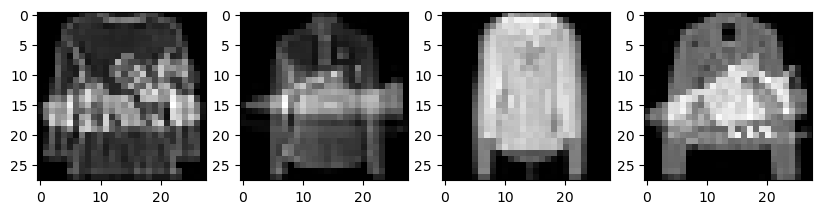

In [36]:
if mixup:
  alpha = 0.9
  mixed_x, y_a, y_b, lam = mixup_data(batch_X, batch_Y,
                                      alpha=alpha)
  plot_mixed_images(mixed_x[:4])

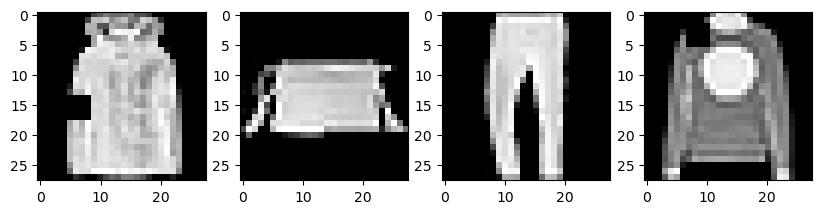

In [23]:
if cutout:
    plot_mixed_images(batch_X[:4])

### Training Loop

In [18]:
#Model and Optimizer Setup
aug_type = "MixUp" # [Choice "NoAug", "CutOut", "MixUp"]

net = get_resnet18(in_channels=1, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=base_learning_rate, betas=(b1, b2))
test_acc_list = []
best_acc = 0
net = net.to(device)
for i in range(start_epoch, end_epoch):
    if aug_type == "MixUp":
        train_one_epoch_mixup(net, trainloader, criterion, optimizer, i)    
    else: 
        train_one_epoch(net, trainloader, criterion, optimizer, i)    
    acc = test(net, testloader)
    if best_acc < acc:
        best_acc = acc
    test_acc_list.append(acc)
    

Epoch: 0: 100%|██████████| 1875/1875 [01:31<00:00, 20.39batch/s, Loss=1.17] 


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 55.03batch/s]


Accuracy of the network on the 10000 test images: 84.24 %


Epoch: 1: 100%|██████████| 1875/1875 [01:21<00:00, 22.95batch/s, Loss=0.893]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 56.02batch/s]


Accuracy of the network on the 10000 test images: 85.93 %


Epoch: 2: 100%|██████████| 1875/1875 [01:19<00:00, 23.46batch/s, Loss=0.912]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 55.95batch/s]


Accuracy of the network on the 10000 test images: 87.68 %


Epoch: 3: 100%|██████████| 1875/1875 [01:22<00:00, 22.77batch/s, Loss=0.691]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 54.94batch/s]


Accuracy of the network on the 10000 test images: 88.99 %


Epoch: 4: 100%|██████████| 1875/1875 [01:20<00:00, 23.44batch/s, Loss=1.15] 


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 53.38batch/s]


Accuracy of the network on the 10000 test images: 89.32 %


Epoch: 5: 100%|██████████| 1875/1875 [01:25<00:00, 22.06batch/s, Loss=0.54] 


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 53.64batch/s]


Accuracy of the network on the 10000 test images: 89.58 %


Epoch: 6: 100%|██████████| 1875/1875 [01:21<00:00, 22.98batch/s, Loss=0.531]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 54.56batch/s]


Accuracy of the network on the 10000 test images: 90.21 %


Epoch: 7: 100%|██████████| 1875/1875 [01:22<00:00, 22.68batch/s, Loss=0.716]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 55.21batch/s]


Accuracy of the network on the 10000 test images: 89.8 %


Epoch: 8: 100%|██████████| 1875/1875 [01:20<00:00, 23.20batch/s, Loss=0.95] 


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 53.96batch/s]


Accuracy of the network on the 10000 test images: 89.79 %


Epoch: 9: 100%|██████████| 1875/1875 [01:22<00:00, 22.78batch/s, Loss=0.631]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 55.66batch/s]

Accuracy of the network on the 10000 test images: 90.17 %


### Saving Traning Information

In [20]:
save_information(aug_type, test_acc_list, best_acc)

### Task 3: Training on different Augmentation

Train on 3 different augmentation mode and visualize the results from below.You can change the hyper-parameters such as alpha, n_holes, etc to see the effect of augmentation techinque. Value of Flags to set for different Augmentation Technque


| **cutout** | **mixup** | **aug_type** |
|------------|-----------|-------------|
| True       | False     | CutOut      |
| False      | True      | MixUp       |
| False      | False     | NoAug       |

### Danger Zone
Don't run the given code unless you have trained on 3 augmentation techinques
Below code is for visualization of test accuracy of different augmentation techniques at different epochs.


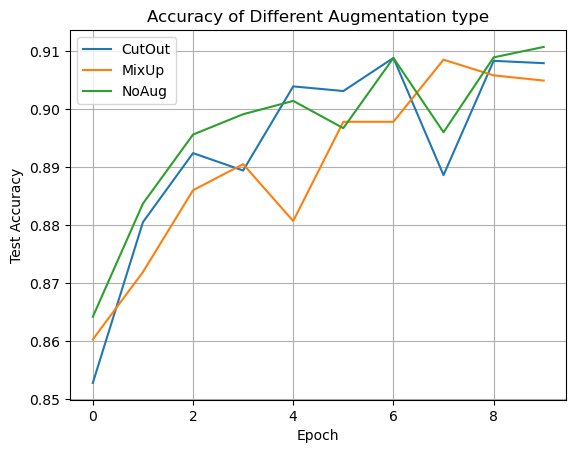

In [20]:
augs_type = ["CutOut","MixUp","NoAug"]
fig, ax = plt.subplots()
for type in augs_type:
    with open(f"training_information{type}.pkl", "rb") as f:
        train_dict = pickle.load(f)
    ax.plot(list(range(start_epoch, end_epoch)), train_dict["accs"], label=type)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.set_title("Accuracy of Different Augmentation type")
ax.legend()
ax.grid(True)
plt.show()
